# Motor Predictive Maintenance - Real-Time Data Analysis v2

## Data Format Support
This notebook automatically detects and handles both data formats:

**Format 1 (No timestamps):**
```
ax_g,ay_g,az_g,mic_raw,temp_C
```

**Format 2 (With timestamps):**
```
timestamp,ax_g,ay_g,az_g,mic_raw,temp_C
```

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.fft import fft, fftfreq
from datetime import datetime

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

print('✓ Libraries loaded successfully')

✓ Libraries loaded successfully


## 1. Smart Data Loading (Auto-detects format)

In [2]:
# Load data - automatically detect format and normalize timestamps
def load_motor_data(filename='motor_data_20251110_goodmotorlados.csv'):
    """Smart loader that handles both formats and normalizes timestamps"""
    
    # Try to read first few lines to detect format
    with open(filename, 'r') as f:
        first_line = f.readline().strip()
        second_line = f.readline().strip()
        third_line = f.readline().strip()
    
    # Count commas to determine number of columns
    num_cols = first_line.count(',') + 1
    
    if num_cols == 5:  # Has timestamps: timestamp,ax_g,ay_g,az_g,temp_C
        print("✓ Detected format: WITH timestamps")
        df = pd.read_csv(filename)
        
        # Check timestamp format
        first_ts = df['timestamp'].iloc[0]
        first_ts_str = str(first_ts)
        second_ts_str = str(df['timestamp'].iloc[1])
        
        # Check if timestamps are Unix timestamps (numeric, large values > 1000000000)
        is_unix_timestamp = False
        try:
            first_ts_float = float(first_ts)
            # Unix timestamps are typically > 1000000000 (year 2001) and < 9999999999 (year 2286)
            if first_ts_float > 1000000000 and first_ts_float < 9999999999:
                is_unix_timestamp = True
        except (ValueError, TypeError):
            pass
        
        # Check if timestamps are in ISO format (YYYY-MM-DD)
        is_iso_format = not is_unix_timestamp and '-' in first_ts_str and first_ts_str.count('-') == 2 and len(first_ts_str) > 10 and first_ts_str[4] == '-'
        
        # Check if first timestamp has date and second doesn't (inconsistent format)
        needs_normalization = not is_unix_timestamp and '/' in first_ts_str and ' ' in first_ts_str and ':' in second_ts_str and '/' not in second_ts_str
        
        if needs_normalization:
            print("⚠️  Detected inconsistent timestamp format - normalizing...")
            
            # Parse first timestamp to extract date and hour
            try:
                # First timestamp format: "10/11/25 18:41" or similar
                first_parts = first_ts.split(' ')
                date_part = first_parts[0]  # "10/11/25"
                time_part = first_parts[1] if len(first_parts) > 1 else "00:00"  # "18:41"
                
                # Extract hour from first timestamp
                hour_min = time_part.split(':')
                base_hour = hour_min[0]  # "18"
                
                # Normalize all timestamps
                normalized_timestamps = []
                for idx, ts in enumerate(df['timestamp']):
                    ts_str = str(ts)
                    
                    if '/' in ts_str and ' ' in ts_str:
                        # Full timestamp with date - check if it has seconds
                        if ts_str.count(':') == 1:
                            # Only has hour:minute, add seconds
                            normalized_timestamps.append(f"{ts_str}:00.0")
                        else:
                            # Already has seconds - use as is
                            normalized_timestamps.append(ts_str)
                    elif ':' in ts_str and '/' not in ts_str:
                        # Time only - prepend date and hour
                        # Format: "41:55.1" -> "10/11/25 18:41:55.1"
                        time_only = ts_str
                        if '.' in time_only:
                            # Has milliseconds: "41:55.1"
                            normalized_ts = f"{date_part} {base_hour}:{time_only}"
                        else:
                            # No milliseconds: "41:55"
                            normalized_ts = f"{date_part} {base_hour}:{time_only}.0"
                        normalized_timestamps.append(normalized_ts)
                    else:
                        # Fallback - try to parse as is
                        normalized_timestamps.append(ts_str)
                
                df['timestamp'] = normalized_timestamps
                print(f"✓ Normalized {len(normalized_timestamps)} timestamps")
                
            except Exception as e:
                print(f"⚠️  Warning: Could not normalize timestamps: {e}")
                print("   Attempting to parse as-is...")
        
        # Convert to datetime or handle Unix timestamps
        try:
            # Save original timestamps before parsing
            original_timestamps = df['timestamp'].copy()
            
            if is_unix_timestamp:
                # Unix timestamp format - convert to datetime and calculate elapsed time
                print("✓ Detected Unix timestamp format (seconds since epoch)")
                df['timestamp'] = pd.to_datetime(original_timestamps, unit='s', errors='coerce')
                # Calculate elapsed time directly from Unix timestamps (more precise)
                df['elapsed_sec'] = original_timestamps.astype(float) - original_timestamps.iloc[0]
                print("✓ Timestamps converted to datetime, elapsed time calculated")
            elif is_iso_format:
                # ISO format - pandas can parse this directly
                print("✓ Detected ISO format timestamps (YYYY-MM-DD)")
                df['timestamp'] = pd.to_datetime(original_timestamps, errors='coerce')
                df['elapsed_sec'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds()
            else:
                # Try multiple date formats for other formats
                df['timestamp'] = pd.to_datetime(original_timestamps, format='%d/%m/%y %H:%M:%S.%f', errors='coerce')
                if df['timestamp'].isna().any():
                    # Try alternative format without milliseconds
                    df['timestamp'] = pd.to_datetime(original_timestamps, format='%d/%m/%y %H:%M:%S', errors='coerce')
                if df['timestamp'].isna().any():
                    # Try standard format (pandas auto-detection)
                    df['timestamp'] = pd.to_datetime(original_timestamps, errors='coerce')
                df['elapsed_sec'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds()
            
            # Check if conversion was successful
            if df['timestamp'].isna().any():
                print(f"⚠️  Warning: {df['timestamp'].isna().sum()} timestamps could not be parsed")
            else:
                print("✓ All timestamps parsed successfully")
                
        except Exception as e:
            print(f"⚠️  Warning: Error parsing timestamps: {e}")
            print("   Timestamps may not be usable for time-based analysis")
        
        df['reading_num'] = range(1, len(df) + 1)
        has_timestamps = True
        has_timestamps = True
        
    elif num_cols == 4:  # No timestamps: ax_g,ay_g,az_g,temp_C
        print("✓ Detected format: WITHOUT timestamps")
        df = pd.read_csv(filename, header=None, names=['ax_g', 'ay_g', 'az_g', 'temp_C'])
        df['reading_num'] = range(1, len(df) + 1)
        has_timestamps = False
        
    else:
        raise ValueError(f"Unexpected format: {num_cols} columns found. Expected 4 (no timestamp) or 5 (with timestamp)")
    
    return df, has_timestamps

# Load the data
df, has_timestamps = load_motor_data('motor_data_20251110_goodmotorlados.csv')

print(f"\n📊 Data Summary")
print("=" * 60)
print(f"Total readings: {len(df)}")
print(f"Columns: {list(df.columns)}")
if has_timestamps:
    duration = df['elapsed_sec'].max()
    print(f"Duration: {duration:.1f} seconds ({duration/60:.1f} minutes)")
    print(f"Sampling rate: {len(df)/duration:.2f} Hz")
    print(f"Start time: {df['timestamp'].iloc[0]}")
    print(f"End time: {df['timestamp'].iloc[-1]}")
print("=" * 60)

df.head(10)

✓ Detected format: WITH timestamps
✓ Detected Unix timestamp format (seconds since epoch)
✓ Timestamps converted to datetime, elapsed time calculated
✓ All timestamps parsed successfully

📊 Data Summary
Total readings: 29837
Columns: ['timestamp', 'ax_g', 'ay_g', 'az_g', 'temp_C', 'elapsed_sec', 'reading_num']
Duration: 59.7 seconds (1.0 minutes)
Sampling rate: 500.02 Hz
Start time: 2025-11-10 18:41:55.059000015
End time: 2025-11-10 18:42:54.730999947


,timestamp,ax_g,ay_g,az_g,temp_C,elapsed_sec,reading_num
0,2025-11-10 18:41:55.059000015,-0.072,-0.995,0.020,24.91,0.000,1
1,2025-11-10 18:41:55.061000109,-0.036,-0.994,-0.027,24.91,0.002,2
2,2025-11-10 18:41:55.062999964,-0.119,-1.019,0.011,24.91,0.004,3
3,2025-11-10 18:41:55.065000057,-0.041,-1.029,0.038,24.91,0.006,4
4,2025-11-10 18:41:55.066999911,0.024,-0.947,-0.063,24.91,0.008,5
5,2025-11-10 18:41:55.069000006,0.022,-0.963,-0.082,24.91,0.010,6
6,2025-11-10 18:41:55.071000099,0.002,-0.992,-0.024,24.91,0.012,7
7,2025-11-10 18:41:55.072999954,-0.007,-0.996,0.077,24.91,0.014,8
8,2025-11-10 18:41:55.075000048,-0.101,-1.054,0.095,24.91,0.016,9
9,2025-11-10 18:41:55.076999903,-0.011,-0.975,0.036,24.91,0.018,10


## 2. Data Quality & Statistics

In [ ]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*60 + "\n")

# Statistical summary
print("Statistical Summary:")
df[['ax_g', 'ay_g', 'az_g', 'temp_C']].describe()

Missing Values:
timestamp      0
ax_g           0
ay_g           0
az_g           0
temp_C         0
elapsed_sec    0
reading_num    0
dtype: int64


Statistical Summary:


,ax_g,ay_g,az_g,temp_C
count,29837.000000,29837.000000,29837.000000,29837.000000
mean,-0.021301,-0.997291,-0.003267,25.822595
std,0.050905,0.031942,0.047907,1.439802
min,-0.221000,-1.141000,-0.221000,24.690000
25%,-0.055000,-1.019000,-0.035000,25.010000
50%,-0.021000,-0.997000,-0.004000,25.230000
75%,0.012000,-0.976000,0.029000,25.470000
max,0.194000,-0.867000,0.199000,29.070000


In [ ]:
# Calculate vibration magnitude
df['vibration_magnitude'] = np.sqrt(df['ax_g']**2 + df['ay_g']**2 + df['az_g']**2)

# Identify anomalies
print("🚨 Anomaly Detection:\n")

# High vibration (>1.5g)
accel_threshold = 1.5
high_vib = df[df['vibration_magnitude'] > accel_threshold]

if len(high_vib) > 0:
    print(f"⚠️  High Vibration Events: {len(high_vib)} readings (>{accel_threshold}g)")
    if has_timestamps:
        display(high_vib[['timestamp', 'vibration_magnitude', 'ax_g', 'ay_g', 'az_g', 'temp_C']].head(10))
    else:
        display(high_vib[['reading_num', 'vibration_magnitude', 'ax_g', 'ay_g', 'az_g', 'temp_C']].head(10))
else:
    print("✅ No high vibration events detected")

# Temperature extremes
temp_high = df[df['temp_C'] > 32]
if len(temp_high) > 0:
    print(f"\n🌡️  High Temperature Events: {len(temp_high)} readings (>32°C)")
    print(f"   Max: {df['temp_C'].max():.2f}°C")
else:
    print(f"\n✅ Temperature within normal range (max: {df['temp_C'].max():.2f}°C)")

🚨 Anomaly Detection:

✅ No high vibration events detected

✅ Temperature within normal range (max: 29.07°C)


## 3. Time Series Visualization

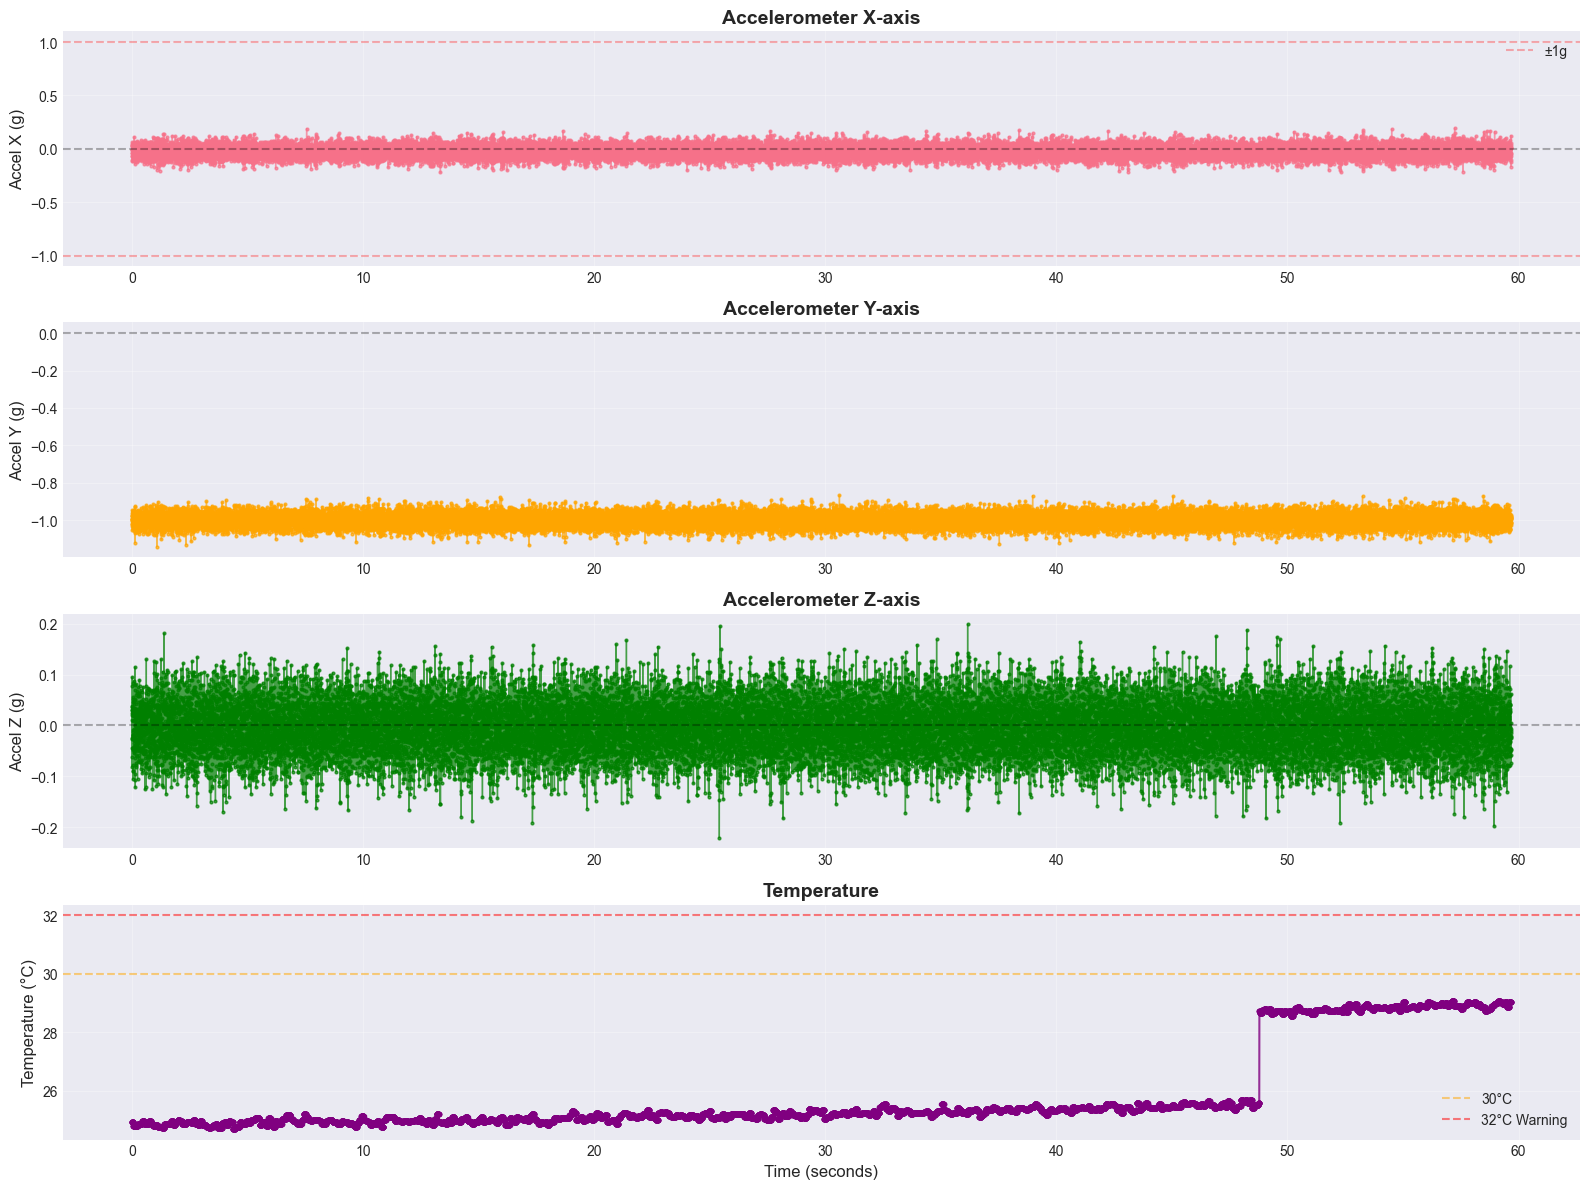

In [ ]:
# Determine x-axis (timestamp or reading number)
x_axis = 'elapsed_sec' if has_timestamps else 'reading_num'
x_label = 'Time (seconds)' if has_timestamps else 'Reading Number'

fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Accelerometer X
axes[0].plot(df[x_axis], df['ax_g'], marker='o', markersize=2, linewidth=1, alpha=0.7)
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0].axhline(y=1, color='r', linestyle='--', alpha=0.3, label='±1g')
axes[0].axhline(y=-1, color='r', linestyle='--', alpha=0.3)
axes[0].set_ylabel('Accel X (g)', fontsize=12)
axes[0].set_title('Accelerometer X-axis', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accelerometer Y
axes[1].plot(df[x_axis], df['ay_g'], marker='o', markersize=2, linewidth=1, alpha=0.7, color='orange')
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1].set_ylabel('Accel Y (g)', fontsize=12)
axes[1].set_title('Accelerometer Y-axis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Accelerometer Z
axes[2].plot(df[x_axis], df['az_g'], marker='o', markersize=2, linewidth=1, alpha=0.7, color='green')
axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[2].set_ylabel('Accel Z (g)', fontsize=12)
axes[2].set_title('Accelerometer Z-axis', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Temperature
axes[3].plot(df[x_axis], df['temp_C'], marker='o', markersize=3, linewidth=1.5, alpha=0.8, color='purple')
axes[3].axhline(y=30, color='orange', linestyle='--', alpha=0.5, label='30°C')
axes[3].axhline(y=32, color='red', linestyle='--', alpha=0.5, label='32°C Warning')
axes[3].set_ylabel('Temperature (°C)', fontsize=12)
axes[3].set_xlabel(x_label, fontsize=12)
axes[3].set_title('Temperature', fontsize=14, fontweight='bold')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Vibration Analysis

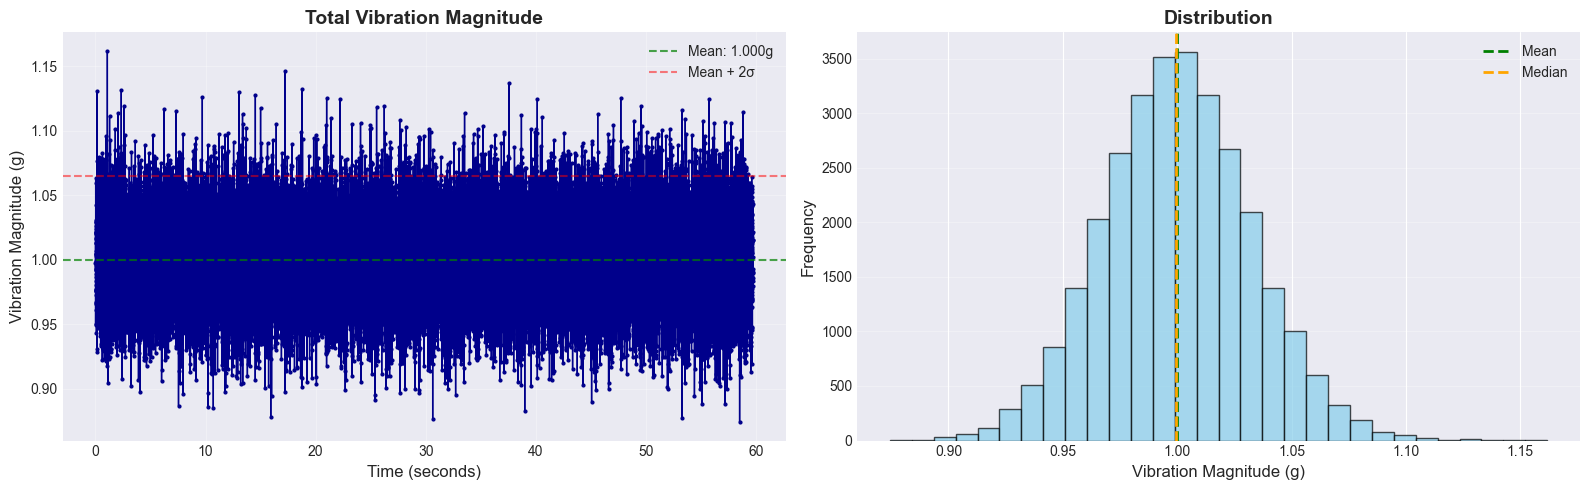

Vibration Statistics:
  Mean: 1.0000g
  Std:  0.0325g
  Max:  1.1617g


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Vibration over time
axes[0].plot(df[x_axis], df['vibration_magnitude'], marker='o', markersize=2, linewidth=1, color='darkblue')
axes[0].axhline(y=df['vibration_magnitude'].mean(), color='green', linestyle='--', 
                alpha=0.7, label=f"Mean: {df['vibration_magnitude'].mean():.3f}g")
axes[0].axhline(y=df['vibration_magnitude'].mean() + 2*df['vibration_magnitude'].std(), 
                color='red', linestyle='--', alpha=0.5, label='Mean + 2σ')
axes[0].set_xlabel(x_label, fontsize=12)
axes[0].set_ylabel('Vibration Magnitude (g)', fontsize=12)
axes[0].set_title('Total Vibration Magnitude', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distribution
axes[1].hist(df['vibration_magnitude'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[1].axvline(x=df['vibration_magnitude'].mean(), color='green', linestyle='--', linewidth=2, label='Mean')
axes[1].axvline(x=df['vibration_magnitude'].median(), color='orange', linestyle='--', linewidth=2, label='Median')
axes[1].set_xlabel('Vibration Magnitude (g)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Vibration Statistics:")
print(f"  Mean: {df['vibration_magnitude'].mean():.4f}g")
print(f"  Std:  {df['vibration_magnitude'].std():.4f}g")
print(f"  Max:  {df['vibration_magnitude'].max():.4f}g")

## 5. Time-Based Analysis (if timestamps available)

⏱️  TIME-BASED ANALYSIS

Actual Sampling Rate: 500.00 Hz
Average interval: 0.002 seconds
Min interval: 0.002 seconds
Max interval: 0.002 seconds


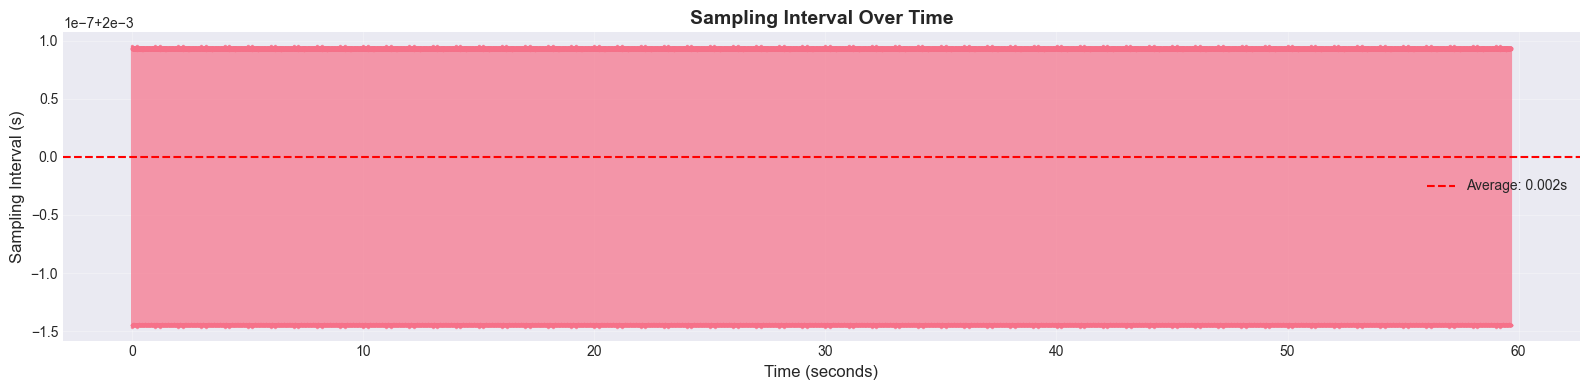


📈 Rates of Change:
  Temperature: 0.0690 °C/s
  Max temp increase: 1569.9262 °C/s
  Max temp decrease: -150.0109 °C/s


In [7]:
if has_timestamps:
    print("⏱️  TIME-BASED ANALYSIS\n")
    
    # Calculate sampling rate
    time_diffs = df['timestamp'].diff().dt.total_seconds()
    avg_interval = time_diffs.mean()
    actual_sampling_rate = 1 / avg_interval if avg_interval > 0 else 0
    
    print(f"Actual Sampling Rate: {actual_sampling_rate:.2f} Hz")
    print(f"Average interval: {avg_interval:.3f} seconds")
    print(f"Min interval: {time_diffs.min():.3f} seconds")
    print(f"Max interval: {time_diffs.max():.3f} seconds")
    
    # Plot sampling intervals
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(df['elapsed_sec'][1:], time_diffs[1:], marker='.', markersize=3, alpha=0.7)
    ax.axhline(y=avg_interval, color='red', linestyle='--', label=f'Average: {avg_interval:.3f}s')
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Sampling Interval (s)', fontsize=12)
    ax.set_title('Sampling Interval Over Time', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate rates of change
    df['temp_rate'] = df['temp_C'].diff() / time_diffs
    df['vibration_rate'] = df['vibration_magnitude'].diff() / time_diffs
    
    print(f"\n📈 Rates of Change:")
    print(f"  Temperature: {df['temp_rate'].mean():.4f} °C/s")
    print(f"  Max temp increase: {df['temp_rate'].max():.4f} °C/s")
    print(f"  Max temp decrease: {df['temp_rate'].min():.4f} °C/s")
    
else:
    print("ℹ️  No timestamps available. Add timestamps for time-based analysis.")
    print("   Use the provided data_collection_with_timestamps.py script!")

## 6. Correlation Analysis

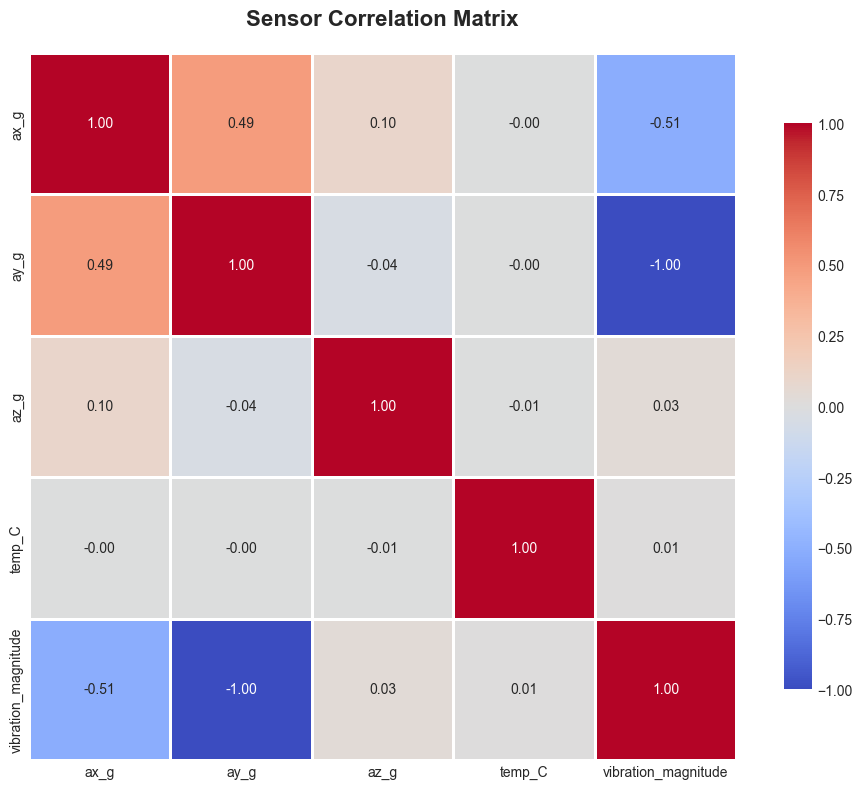

In [ ]:
corr_cols = ['ax_g', 'ay_g', 'az_g', 'temp_C', 'vibration_magnitude']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=2, cbar_kws={"shrink": 0.8}, fmt='.2f',
            vmin=-1, vmax=1)
plt.title('Sensor Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 7. Summary Report

In [ ]:
print("="*70)
print(" MOTOR HEALTH SUMMARY REPORT")
print("="*70)

print(f"\n📊 Dataset:")
print(f"   Total Readings: {len(df)}")
if has_timestamps:
    print(f"   Duration: {df['elapsed_sec'].max()/60:.1f} minutes")
    print(f"   Sampling Rate: {actual_sampling_rate:.2f} Hz")

print(f"\n🔧 Vibration:")
print(f"   Mean: {df['vibration_magnitude'].mean():.4f}g")
print(f"   Std: {df['vibration_magnitude'].std():.4f}g")
print(f"   Max: {df['vibration_magnitude'].max():.4f}g")
high_count = len(df[df['vibration_magnitude'] > 1.5])
print(f"   High Events (>1.5g): {high_count} ({high_count/len(df)*100:.1f}%)")

print(f"\n🌡️  Temperature:")
print(f"   Current: {df['temp_C'].iloc[-1]:.2f}°C")
print(f"   Mean: {df['temp_C'].mean():.2f}°C")
print(f"   Range: {df['temp_C'].min():.2f}°C - {df['temp_C'].max():.2f}°C")

print(f"\n💡 Status:")
if high_count > 5:
    print("   ⚠️  CAUTION: Multiple high vibration events detected")
elif high_count > 0:
    print("   🟡 NORMAL: Some vibration spikes observed")
else:
    print("   ✅ GOOD: Vibration within normal range")

if df['temp_C'].max() > 35:
    print("   🔴 HIGH TEMPERATURE WARNING")
elif df['temp_C'].max() > 32:
    print("   🟡 Elevated temperature observed")
else:
    print("   ✅ Temperature nominal")

print("\n" + "="*70)

 MOTOR HEALTH SUMMARY REPORT

📊 Dataset:
   Total Readings: 29837
   Duration: 1.0 minutes
   Sampling Rate: 500.00 Hz

🔧 Vibration:
   Mean: 1.0000g
   Std: 0.0325g
   Max: 1.1617g
   High Events (>1.5g): 0 (0.0%)

🌡️  Temperature:
   Current: 29.03°C
   Mean: 25.82°C
   Range: 24.69°C - 29.07°C

💡 Status:
   ✅ GOOD: Vibration within normal range
   ✅ Temperature nominal



## 8. Export Data

In [ ]:
# Save processed data
df.to_csv('motor_data_processed.csv', index=False)
print('✓ Processed data saved: motor_data_processed.csv')

# Save summary
summary = df[['ax_g', 'ay_g', 'az_g', 'temp_C', 'vibration_magnitude']].describe()
summary.to_csv('motor_data_summary.csv')
print('✓ Summary saved: motor_data_summary.csv')

✓ Processed data saved: motor_data_processed.csv
✓ Summary saved: motor_data_summary.csv
